In [360]:
import numpy as np
import cv2 as cv
import os
import shutil
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

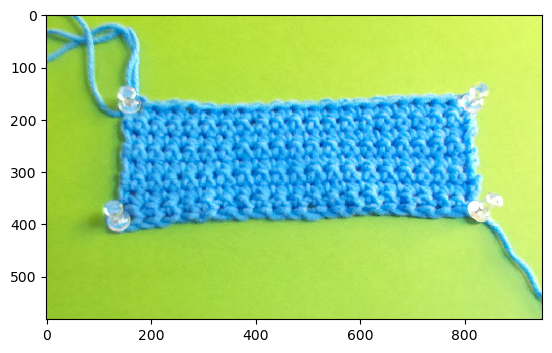

In [361]:
#folder = "../../Documents/ZED2"
folder = "DatasetMod/Negro"
carpeta = "DatasetMod/Negro_cropped"
if os.path.exists(carpeta):
    shutil.rmtree(carpeta)
os.makedirs(carpeta)

auxPath = "DatasetMod/Negro_bin"
if os.path.exists(auxPath):
    shutil.rmtree(auxPath)
os.makedirs(auxPath)

images = []
for filename in os.listdir(folder):
    img = cv.imread(os.path.join(folder,filename), cv.IMREAD_COLOR)
    if img is not None:
        height, width = img.shape[:2]
        cropped = img[50:height-50, 50:width-50]
        images.append(cropped)
    
plt.imshow(images[0], cmap="gray")


In [362]:
def img2Binary(img, i):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    blur = cv.GaussianBlur(img_gray,(5,5),0)
    ret,th = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    cv.imwrite(os.path.join(auxPath, str(i)+".jpg"), th)
    return th
    

In [363]:
def morphOp(th, i):
    kernel = np.ones((5,5),np.uint8)

    # Closing -> Erasing the holes inside the object
    closing = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel, iterations = 3)

    # Opening -> Erasing the tails
    kernel = np.ones((13,13),np.uint8)

    opening = cv.morphologyEx(closing, cv.MORPH_OPEN, kernel, iterations = 1)
    #plt.imshow(opening, cmap="gray")
    return opening


In [364]:
def euclideanDistance(p1, p2):
    # p1, p2 as tuples
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

In [365]:

def ROI(img_rgb, opening, i):
    copy = img_rgb.copy()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    if(len(contours)>0):
        print(i)
        ## Finding the center of the image
        moment = cv.moments(img_gray)
        x = int(moment ["m10"] / moment["m00"])
        y = int(moment ["m01"] / moment["m00"])
        image_center = (x,y)
        cv.circle(copy, image_center, 3, (255, 100, 0), 2)

        ## Finding the biggest contour -> the ROI
        biggestArea = 0
        for cnt in contours:
            area = cv.contourArea(cnt)
            if biggestArea < area:
                biggestArea = area
                biggestContour = cnt
        
        minDistance = float("inf") ## Highest number 
        for cnt in contours:
            # Find the center of each contour
            M = cv.moments(cnt)
            centerX = int(M["m10"] / M["m00"])
            centerY = int(M["m01"] / M["m00"])
            contour_center = (centerX, centerY)

            # Then calculate the distance between the center of the contour and the center of the image
            distance = euclideanDistance(image_center, contour_center)
            if(distance < minDistance):
                minDistance = distance
                mostCenteredContour = cnt

        cv.drawContours(copy, mostCenteredContour, -1, (255,0,0), 3)

        x,y,w,h = cv.boundingRect(mostCenteredContour)
        cv.rectangle(copy,(x,y),(x+w,y+h),(255,0,0),8)

        dst = cv.Canny(img_gray, 0, 150)
        blured = cv.blur(dst, (5,5), 0)

        [X, Y, W, H] = cv.boundingRect(mostCenteredContour)
        cropped = img_rgb[Y:Y+H, X:X+W]
        
        cv.imwrite(os.path.join(carpeta, str(i)+".jpg"), cropped)

A FUNCIONAR

In [366]:
i=0
for img in images:
    th = img2Binary(img, i)
    opening = morphOp(th, i)
    ROI(img, opening, i)
    i += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
